In [0]:
!git clone https://github.com/tensorflow/models.git


Cloning into 'models'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 21592 (delta 3), reused 5 (delta 2), pack-reused 21574
Receiving objects: 100% (21592/21592), 559.32 MiB | 36.84 MiB/s, done.
Resolving deltas: 100% (12699/12699), done.
Checking out files: 100% (2804/2804), done.


In [0]:
!apt-get -qq install libprotobuf-java protobuf-compiler
!protoc ./models/research/object_detection/protos/string_int_label_map.proto --python_out=.
!cp -R models/research/object_detection/ object_detection/
!rm -rf models

Selecting previously unselected package libprotobuf10:amd64.
(Reading database ... 21063 files and directories currently installed.)
Preparing to unpack .../libprotobuf10_3.0.0-9.1ubuntu1_amd64.deb ...
Unpacking libprotobuf10:amd64 (3.0.0-9.1ubuntu1) ...
Selecting previously unselected package libprotoc10:amd64.
Preparing to unpack .../libprotoc10_3.0.0-9.1ubuntu1_amd64.deb ...
Unpacking libprotoc10:amd64 (3.0.0-9.1ubuntu1) ...
Selecting previously unselected package libprotobuf-java.
Preparing to unpack .../libprotobuf-java_3.0.0-9.1ubuntu1_all.deb ...
Unpacking libprotobuf-java (3.0.0-9.1ubuntu1) ...
Selecting previously unselected package protobuf-compiler.
Preparing to unpack .../protobuf-compiler_3.0.0-9.1ubuntu1_amd64.deb ...
Unpacking protobuf-compiler (3.0.0-9.1ubuntu1) ...
Setting up libprotobuf-java (3.0.0-9.1ubuntu1) ...
Setting up libprotobuf10:amd64 (3.0.0-9.1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up libprotoc10:amd64 (3.0.0-9.1ubuntu1) .

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
import matplotlib.pyplot as plt
from PIL import Image
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

/content/object_detection/utils/visualization_utils.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
    retu

In [0]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 10

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())
    
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
!mkdir images

In [0]:
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

In [0]:
from google.colab import files

In [0]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [0]:
upload_files()

In [0]:
PATH_TO_TEST_IMAGES_DIR = 'images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'frame{}.png'.format(i)) for i in range(6, 7) ]

IMAGE_SIZE = (12, 8)

In [0]:
import cv2
print(TEST_IMAGE_PATHS)

['images/frame6.png']


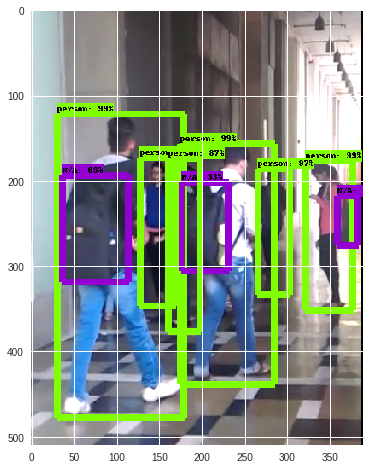

In [0]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      image_np = load_image_into_numpy_array(image)
      image_np_expanded = np.expand_dims(image_np, axis=0)
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)
      cv2.imwrite("output.jpg",boxes)

In [0]:
import cv2
#Reading the video
vidcap = cv2.VideoCapture('images/vid1.mp4')


In [0]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    while True:
      ret, image_np = vidcap.read()
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)

      cv2.imshow('object detection', cv2.resize(image_np, (500,400)))
      if cv2.waitKey(25) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

In [0]:
print(boxes.shape)

(1, 100, 4)


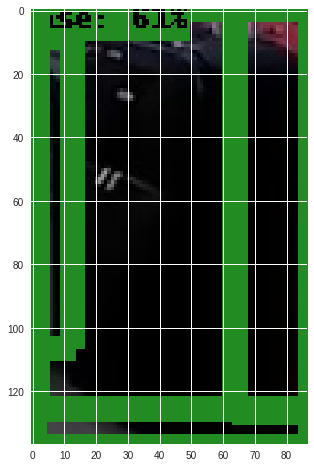

In [0]:
ymin = boxes[0,5,0]
xmin = boxes[0,5,1]
ymax = boxes[0,5,2]
xmax = boxes[0,5,3]
(im_width, im_height) = image.size
(xminn, xmaxx, yminn, ymaxx) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
cropped_image = tf.image.crop_to_bounding_box(image_np, int(yminn), int(xminn),int(ymaxx - yminn), int(xmaxx - xminn))
sess = tf.Session()
img_data = sess.run(cropped_image)
sess.close()

plt.figure(figsize=IMAGE_SIZE)
plt.imshow(img_data)